# Data description

`telecom_users.csv` consinsts of:<br><br>

&nbsp;&nbsp;&nbsp;&nbsp; `customerID` – client id<br>
&nbsp;&nbsp;&nbsp;&nbsp; `gender` – (male/female)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `SeniorCitizen` – (1, 0)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Partner` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Dependents` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `tenure` – how long does client use company's service<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PhoneService` – telephone service (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MultipleLines` – (Yes, No, No phone service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `InternetService` – (DSL, Fiber optic, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineSecurity` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `OnlineBackup` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `DeviceProtection` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TechSupport` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingTV` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `StreamingMovies` – (Yes, No, No internet service)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Contract` – (Month-to-month, One year, Two year)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaperlessBilling` – (Yes, No)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `PaymentMethod` – (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))<br>
&nbsp;&nbsp;&nbsp;&nbsp; `MonthlyCharges` – (number)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `TotalCharges` – (number)<br>
&nbsp;&nbsp;&nbsp;&nbsp; `Churn` – (Yes or No)<br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [2]:
def stacking(models, meta_alg, data_train, targets_train, data_test, 
             targets_test=None, random_state=None, test_size=None, cv=5):
    
    if test_size is None:
        meta_mtrx = np.empty((data_train.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, 
                                                cv=cv, method='predict')
            model.fit(data_train, targets_train)
        
        meta = meta_alg.fit(meta_mtrx, targets_train)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
            
        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Recall score {recall_score(targets_test, meta_predict)}')
            
        return meta_predict
    
    elif test_size > 0 and test_size < 1:
        train, valid, train_true, valid_true = train_test_split(data_train, 
                                                                 targets_train,
                                                                 train_size=test_size,
                                                                 random_state=random_state)
        meta_mtrx = np.empty((valid.shape[0], len(models)))
        for n, model in enumerate(models):
            class_model = model.fit(train, train_true)
            meta_mtrx[:, n] = class_model.predict(valid)
        
        meta = meta_alg.fit(meta_mtrx, valid_true)
        
        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))
        for n, model in enumerate(models):
            meta_mtrx_test[:, n] = model.predict(data_test)
        
        meta_predict = meta.predict(meta_mtrx_test)
        
        if targets_test is not None:
            print(f'Accuracy score {accuracy_score(y_test, meta_predict)}')
            print(f'Recall score {recall_score(targets_test, meta_predict)}')
    
    else:
        raise ValueError("test_size must be between 0 and 1")

In [3]:
def hist_plot(df, parameter, n_bins):
    df[parameter].hist(bins=n_bins)
    plt.title(f'Parameter {parameter}')
    plt.show()

In [4]:
def category_plot(df, parameter):
    plt.figure(figsize = (10,8))
    sns.set(style = 'whitegrid')
    sns.countplot(df[parameter], hue = df.Churn)

# 1. Data preparation and high level analysis

In [5]:
dataframe = pd.read_csv('telecom_users.csv')
dataframe = dataframe.drop(columns=['Unnamed: 0', 'customerID'], axis=1)
dataframe.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [6]:
dataframe.shape

(5986, 20)

There are 5986 objects in dataframe, 19 features and target value Churn.

Get data types in the dataframe

In [7]:
dataframe.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### Gender feature

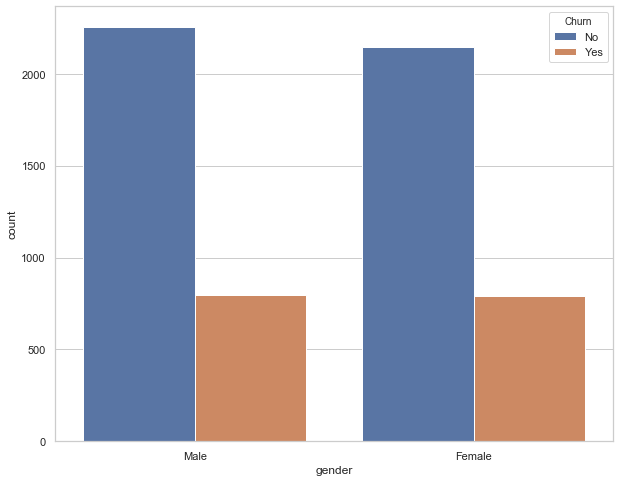

In [8]:
category_plot(dataframe, 'gender')

In [9]:
dataframe.gender.value_counts()

Male      3050
Female    2936
Name: gender, dtype: int64

Noted that male clients is 114 more than female clients. In general it could be said that ditribution based on gender is almost equal.

#### SeniorCitizen feature

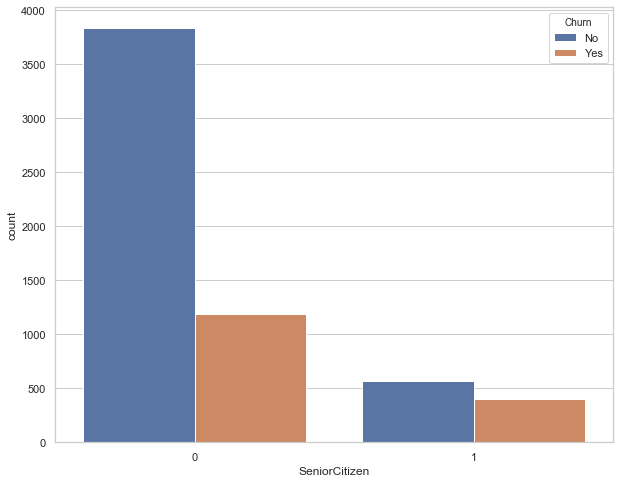

In [10]:
category_plot(dataframe, 'SeniorCitizen')

In [11]:
dataframe.SeniorCitizen.value_counts()

0    5020
1     966
Name: SeniorCitizen, dtype: int64

Senior citizen fraction is equal to 16%.

#### Partner feature

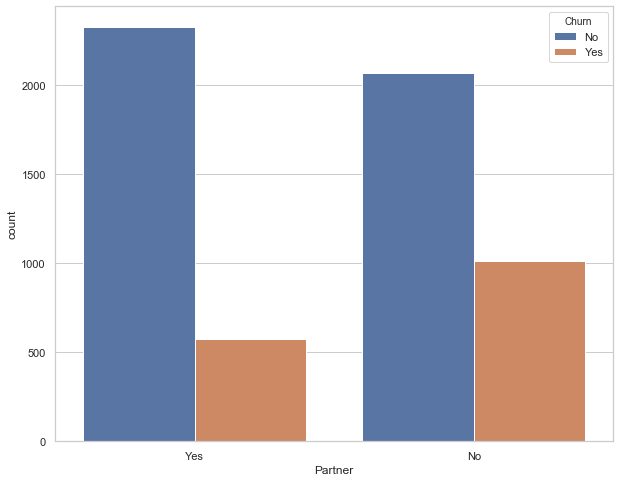

In [12]:
category_plot(dataframe, 'Partner')

In [13]:
dataframe.Partner.value_counts()

No     3082
Yes    2904
Name: Partner, dtype: int64

Number of clients without partners is 178 more than clients with.

#### Dependents features

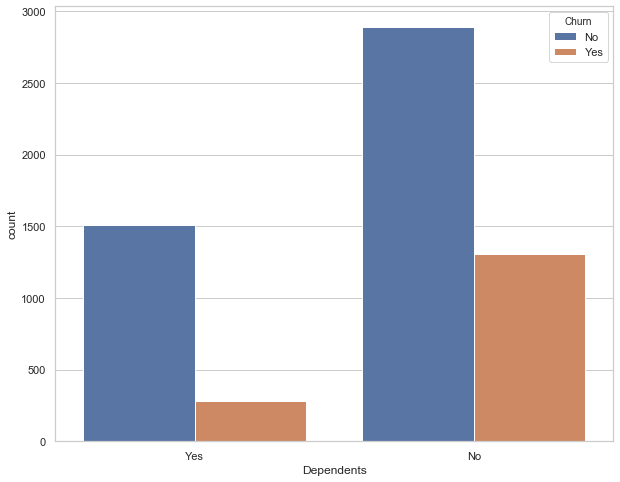

In [14]:
category_plot(dataframe, 'Dependents')

In [15]:
dataframe.Dependents.value_counts()

No     4195
Yes    1791
Name: Dependents, dtype: int64

70% of clients have not dependents and churn rate for them is high.

#### Tenure feature

In [16]:
dataframe.tenure.describe()

count    5986.000000
mean       32.468760
std        24.516391
min         0.000000
25%         9.000000
50%        29.000000
75%        56.000000
max        72.000000
Name: tenure, dtype: float64

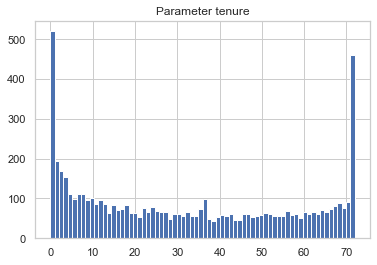

In [17]:
hist_plot(dataframe, 'tenure', 70)

Bimodal distribution shows that company has significant amount of regular clients (more than 4 years), but also has high number of new clients.

#### PhoneService feature

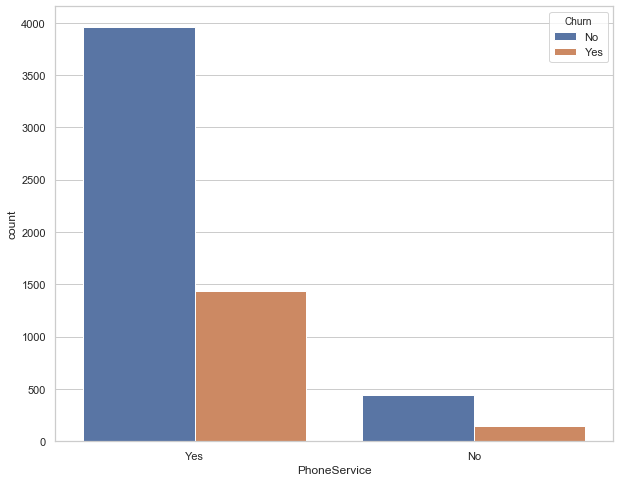

In [18]:
category_plot(dataframe, 'PhoneService')

In [19]:
dataframe.PhoneService.value_counts()

Yes    5396
No      590
Name: PhoneService, dtype: int64

About 90% of clients have phone service activated.

#### MultipleLines feature

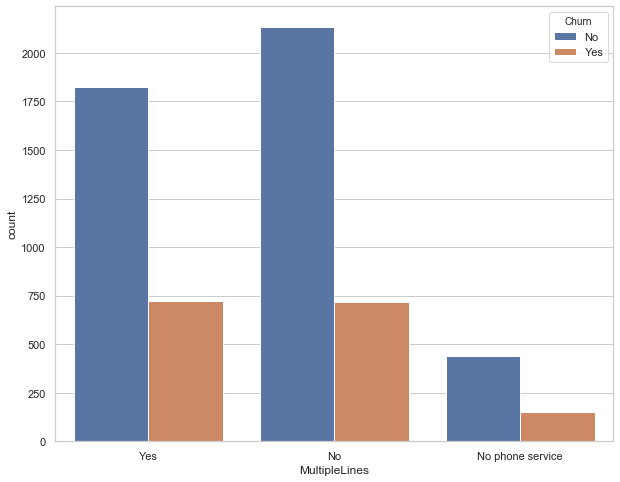

In [20]:
category_plot(dataframe, 'MultipleLines')

In [21]:
dataframe.MultipleLines.value_counts()

No                  2848
Yes                 2548
No phone service     590
Name: MultipleLines, dtype: int64

Number of clients with miltiple lines activated (2548) is almost equal to number of clients without activation of this feature (2848).

#### InternetService feature

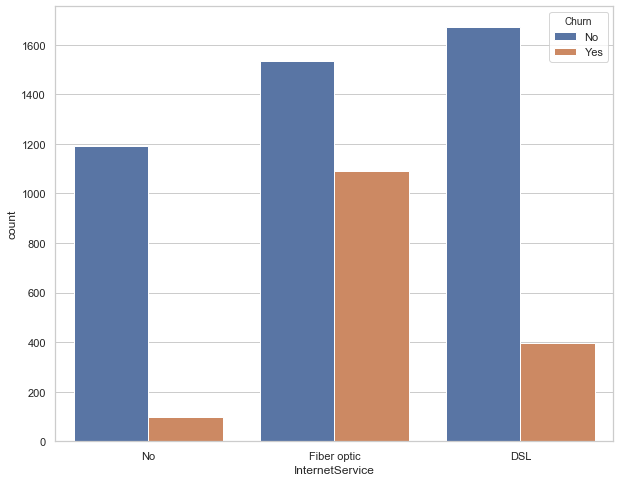

In [22]:
category_plot(dataframe, 'InternetService')

In [23]:
dataframe.InternetService.value_counts()

Fiber optic    2627
DSL            2068
No             1291
Name: InternetService, dtype: int64

44% of clients use Fiber optic and 35% DSL. High churn rate for clients with Fibre optic.

#### OnlineSecurity feature

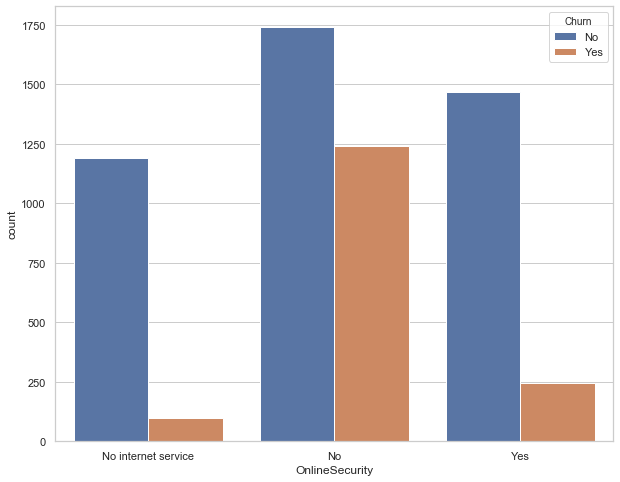

In [24]:
category_plot(dataframe, 'OnlineSecurity')

In [25]:
dataframe.OnlineSecurity.value_counts()

No                     2982
Yes                    1713
No internet service    1291
Name: OnlineSecurity, dtype: int64

50% of clients have not activated online security feature, churn rate is also high.

#### OnlineBackup feature

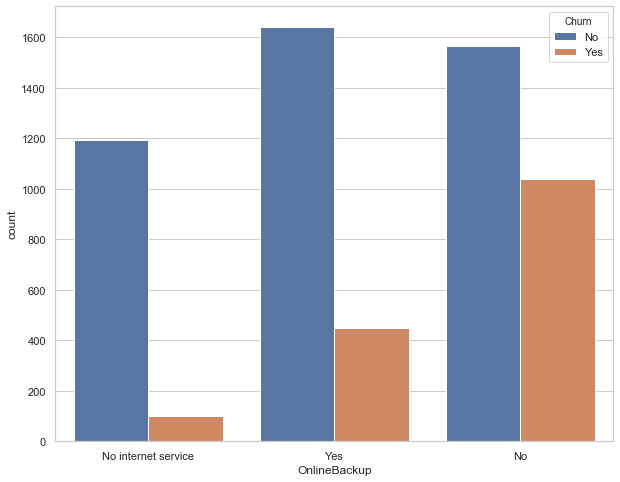

In [26]:
category_plot(dataframe, 'OnlineBackup')

In [27]:
dataframe.OnlineBackup.value_counts()

No                     2605
Yes                    2090
No internet service    1291
Name: OnlineBackup, dtype: int64

44% of clients have not activated online backup feature (high churn rate), but 35% have this feature activated.

#### DeviceProtection feature

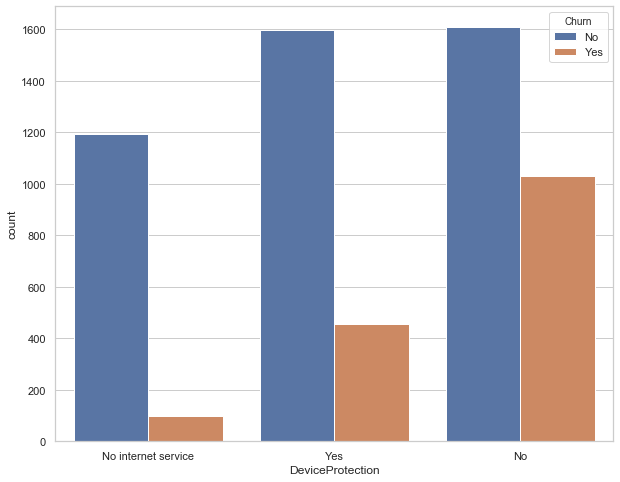

In [28]:
category_plot(dataframe, 'DeviceProtection')

In [29]:
dataframe.DeviceProtection.value_counts()

No                     2640
Yes                    2055
No internet service    1291
Name: DeviceProtection, dtype: int64

44% of clients have no device protection (high churn rate).

#### TechSupport feature

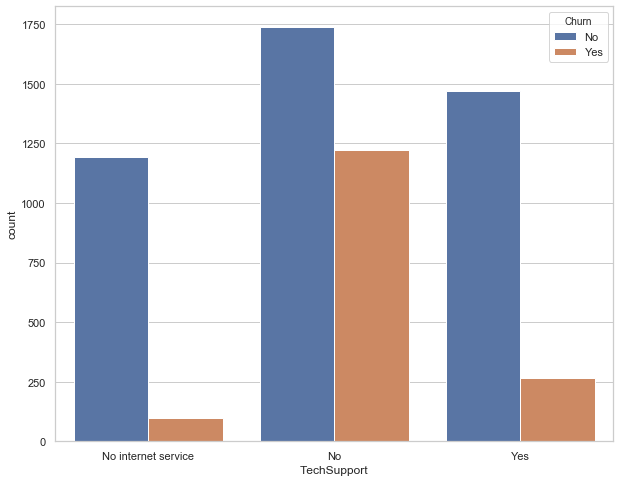

In [30]:
category_plot(dataframe, 'TechSupport')

In [31]:
dataframe.TechSupport.value_counts()

No                     2960
Yes                    1735
No internet service    1291
Name: TechSupport, dtype: int64

50% of clients did not activate tech support service (high churn rate for them).

#### StreamingTV feature

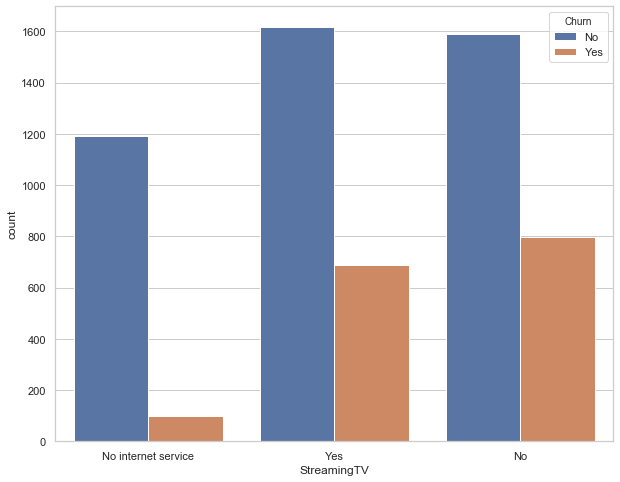

In [32]:
category_plot(dataframe, 'StreamingTV')

In [33]:
dataframe.StreamingTV.value_counts()

No                     2389
Yes                    2306
No internet service    1291
Name: StreamingTV, dtype: int64

Among clients with internet service activated there is 50% of them with streaming TV and 50% without (high churn rate).

#### StreamingMovies feature

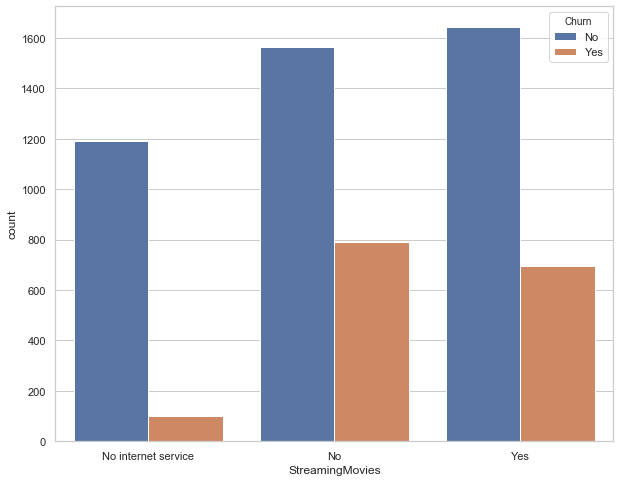

In [34]:
category_plot(dataframe, 'StreamingMovies')

In [35]:
dataframe.StreamingMovies.value_counts()

No                     2356
Yes                    2339
No internet service    1291
Name: StreamingMovies, dtype: int64

Among clients with internet service activated there is 50% of them with streaming movies activated feature and 50% without.

#### Contract feature

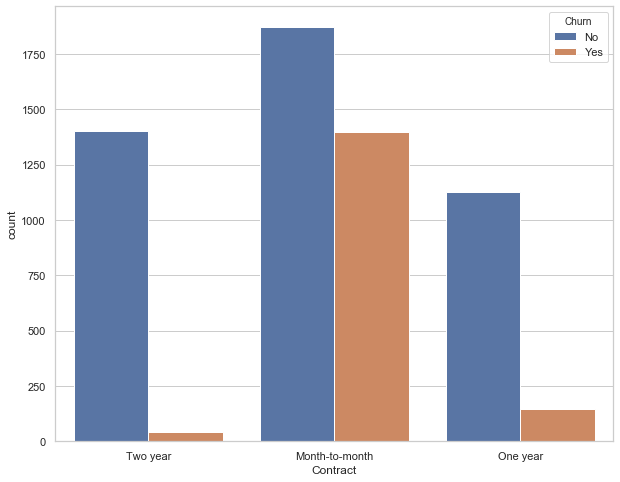

In [36]:
category_plot(dataframe, 'Contract')

In [37]:
dataframe.Contract.value_counts()

Month-to-month    3269
Two year          1441
One year          1276
Name: Contract, dtype: int64

55% of clients have month-to-month contract (high churn rate).

#### PaperlessBilling feature

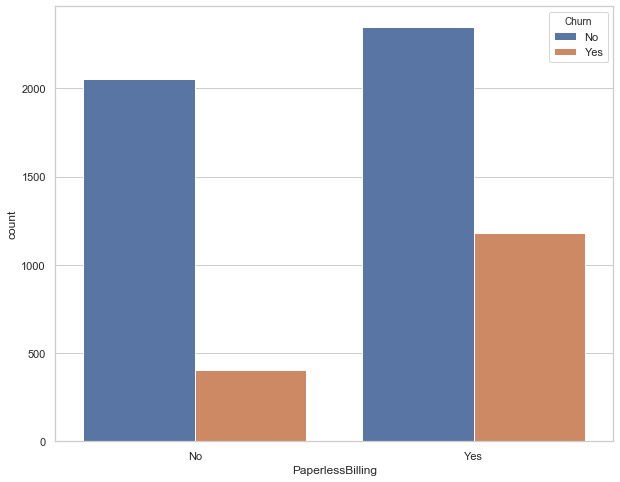

In [38]:
category_plot(dataframe, 'PaperlessBilling')

In [39]:
dataframe.PaperlessBilling.value_counts()

Yes    3528
No     2458
Name: PaperlessBilling, dtype: int64

59% of clients use paperless billing (higher churn rate).

#### PaymentMethod feature

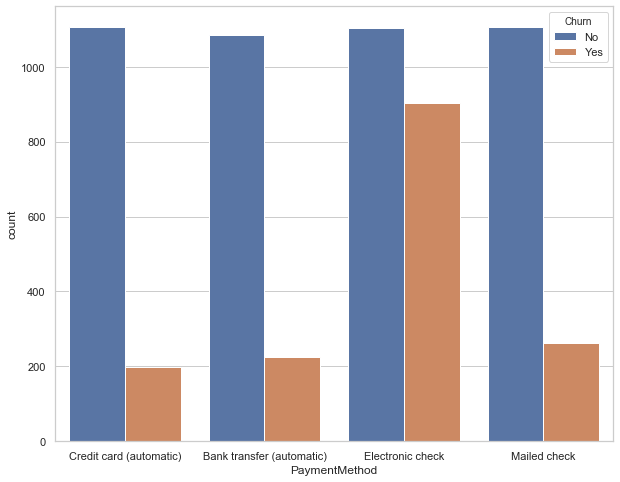

In [40]:
category_plot(dataframe, 'PaymentMethod')

In [41]:
dataframe.PaymentMethod.value_counts()

Electronic check             2006
Mailed check                 1369
Bank transfer (automatic)    1308
Credit card (automatic)      1303
Name: PaymentMethod, dtype: int64

33% of clients use Electronic check as payment method (high churn rate among them).

#### MonthlyCharges feature

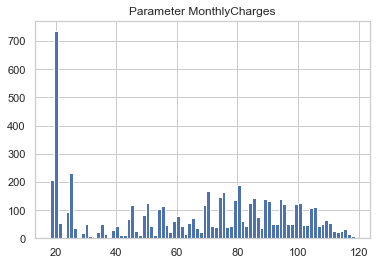

In [42]:
hist_plot(dataframe, 'MonthlyCharges', 80)

In [43]:
dataframe.MonthlyCharges.describe()

count    5986.000000
mean       64.802213
std        30.114702
min        18.250000
25%        35.650000
50%        70.400000
75%        89.900000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [44]:
dataframe.MonthlyCharges.mode()

0    20.05
dtype: float64

As could be seen from distribution, we presume this is bimodal with pronounced main mode at 20.05.

#### TotalCharges feature

In [45]:
type(dataframe.iloc[0, -2])  # values in TotalCharges as of 'str' type

str

Column TotalCharges with values of type 'str. There are absent values in this column: `' '`

In [46]:
dataframe.replace(' ', np.nan, inplace=True)
dataframe.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        10
Churn                0
dtype: int64

Remove nan values (rows) from the whole dataset: there are only 10 of them, which is 0.16% of the total rows - this will not impact on result.

In [47]:
dataframe.dropna(inplace=True)
dataframe.shape

(5976, 20)

In [48]:
dataframe['TotalCharges'] = dataframe['TotalCharges'].astype(float) 

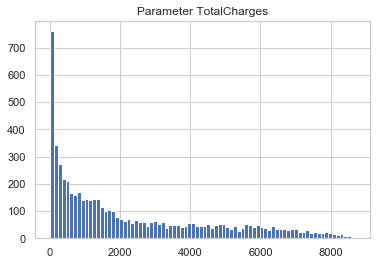

In [49]:
hist_plot(dataframe, 'TotalCharges', 80)

In [50]:
dataframe.TotalCharges.describe()

count    5976.000000
mean     2298.060617
std      2274.127165
min        18.800000
25%       404.312500
50%      1412.150000
75%      3846.962500
max      8684.800000
Name: TotalCharges, dtype: float64

There is a unimodal distribution with positive coefficient of skewness and positive coefficient of kurtosis. A lot of clients has low sum of payment over all time.

#### Target value Churn

In [51]:
dataframe.Churn.value_counts()

No     4389
Yes    1587
Name: Churn, dtype: int64

27% of cluents have churn.

#### Train and test datasets

# 2. Investigation of dependencies and hypothesis formulation

#### Hypothesis 1: method of payment is relevant to churn

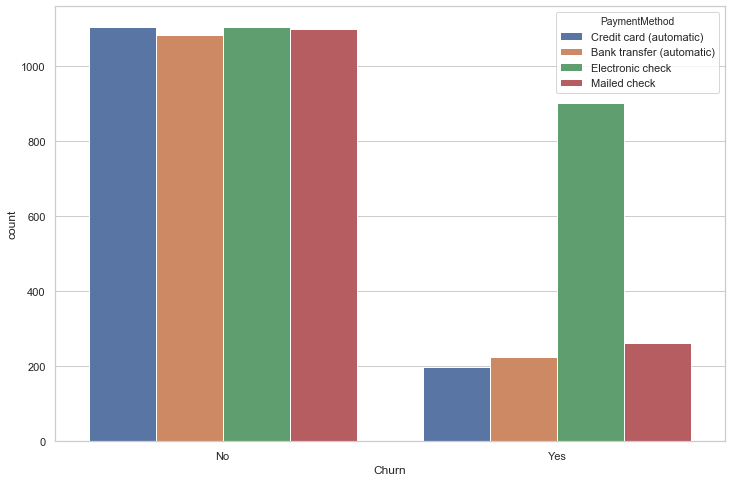

In [52]:
plt.figure(figsize=(12,8))
sns.countplot(x='Churn', hue='PaymentMethod', data=dataframe)
plt.show()

Clients with electronic check as payment methid has high churn rate.

Let's have a look at these particular clients:

In [66]:
electronic_check = dataframe[(dataframe['PaymentMethod'] == 'Electronic check')
                            & (dataframe['Churn'] == 'Yes')]

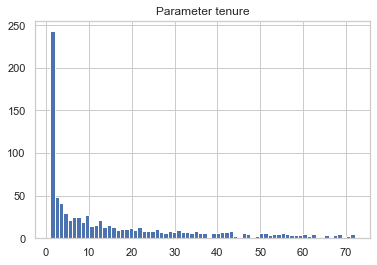

In [67]:
hist_plot(electronic_check, 'tenure', 70)

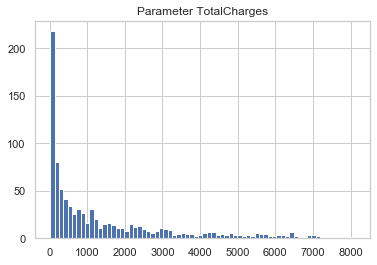

In [77]:
hist_plot(electronic_check, 'TotalCharges', 70)

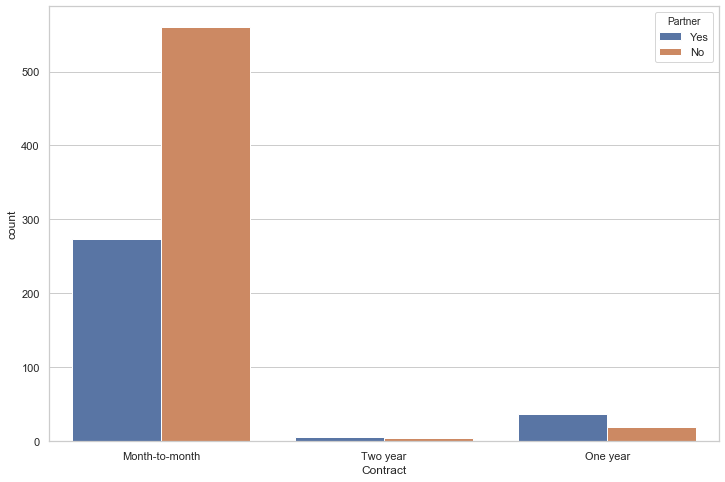

In [79]:
plt.figure(figsize=(12,8))
sns.countplot(x='Contract', hue='Partner', data=electronic_check)
plt.show()

Proposed portrait of client for high churn rate: client with month-to-month contract, without partner, using electronic check as payment method, recently started using company services.

#### Hypothesis 2: using internet service is relevant to churn

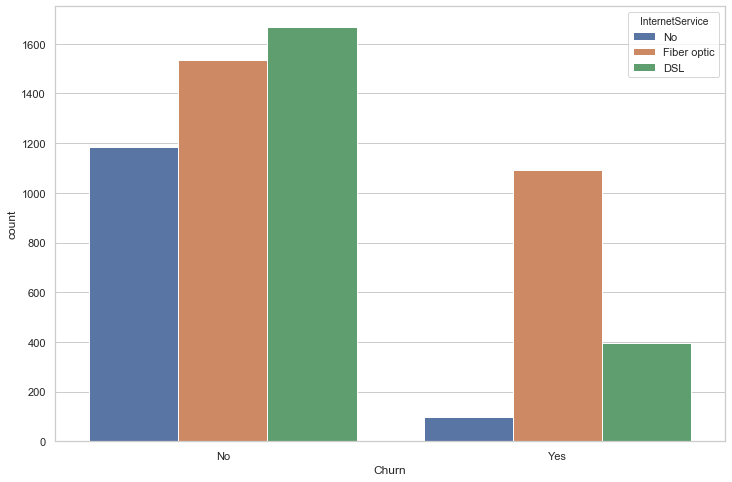

In [55]:
plt.figure(figsize=(12,8))
sns.countplot(x='Churn', hue='InternetService', data=dataframe)
plt.show()

There is high churn rate for the clients using fiber optic internet connection

Let's consider these clients

In [75]:
optic_fiber = dataframe[(dataframe['InternetService'] == 'Fiber optic')
                        & (dataframe['Churn'] == 'Yes')]

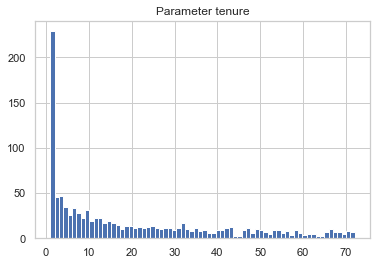

In [76]:
hist_plot(optic_fiber, 'tenure', 70)

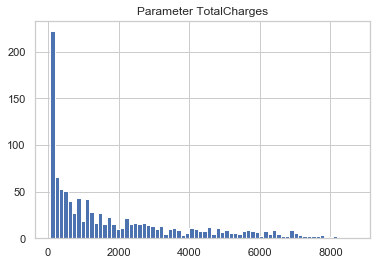

In [78]:
hist_plot(optic_fiber, 'TotalCharges', 70)

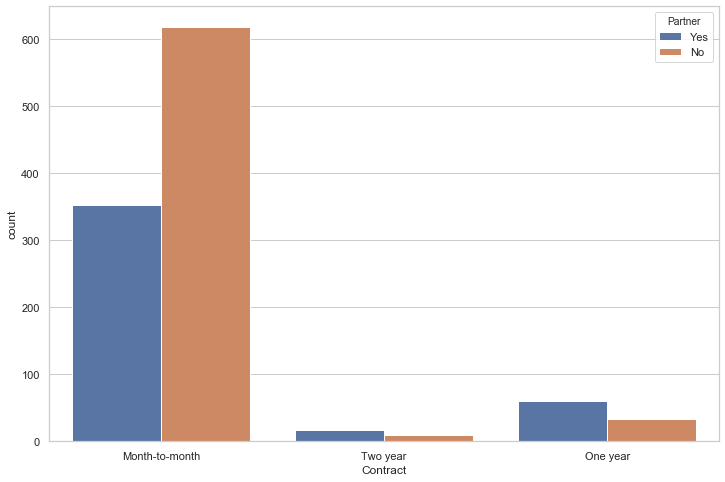

In [80]:
plt.figure(figsize=(12,8))
sns.countplot(x='Contract', hue='Partner', data=optic_fiber)
plt.show()

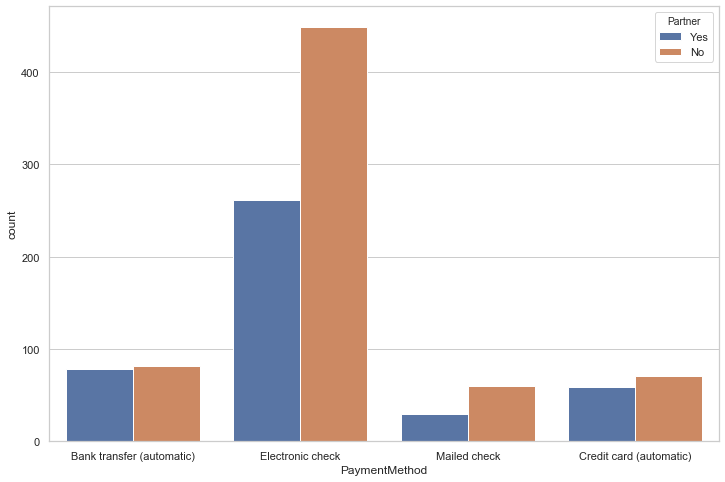

In [81]:
plt.figure(figsize=(12,8))
sns.countplot(x='PaymentMethod', hue='Partner', data=optic_fiber)
plt.show()

Proposed portrait of client for high churn rate: client with month-to-month contract, using fiber optic as internet service, without partner, using electronic check as payment method, recently started using company services.

#### Hypothesis 3: having partner is relevant to churn rate

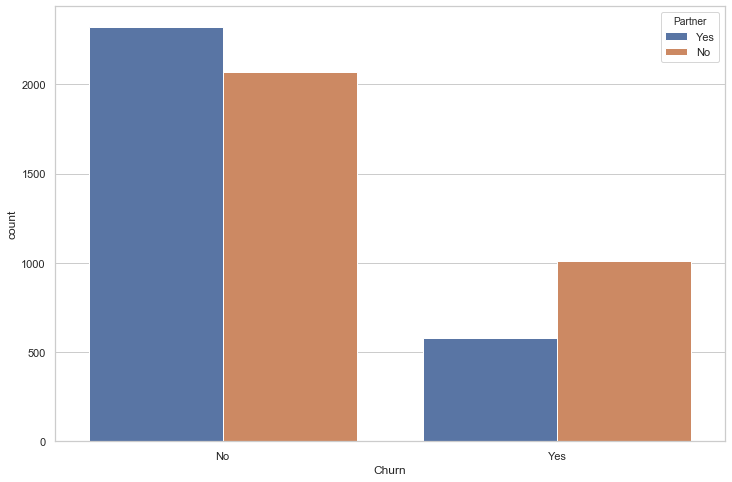

In [56]:
plt.figure(figsize=(12,8))
sns.countplot(x='Churn', hue='Partner', data=dataframe)
plt.show()

High churn rate is typical for clients without partner

#### Hypothesis 4: Presence of the dependat is relevant to churn rate

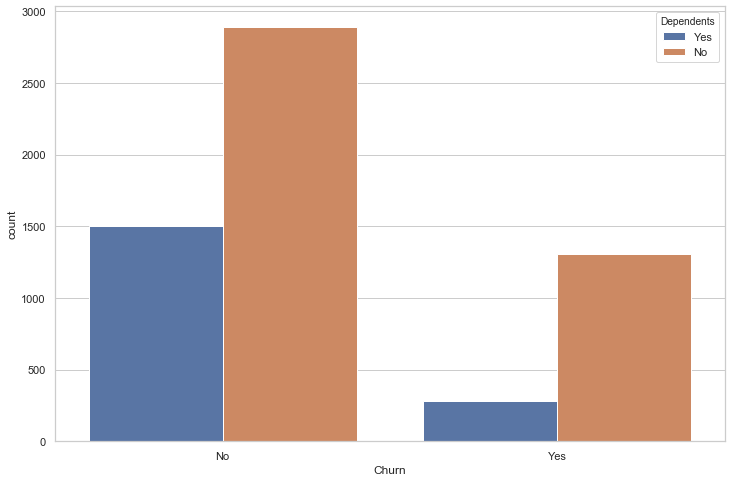

In [57]:
plt.figure(figsize=(12,8))
sns.countplot(x='Churn', hue='Dependents', data=dataframe)
plt.show()

Clients without dependants have higher churn rate

#### Hypothesis 5: is there relation between seniority of citizen and churn rate

In [58]:
senior_citizen_churn = (dataframe[dataframe['SeniorCitizen'] == 1][['Churn', 'SeniorCitizen']]
                        .reset_index(drop=True))

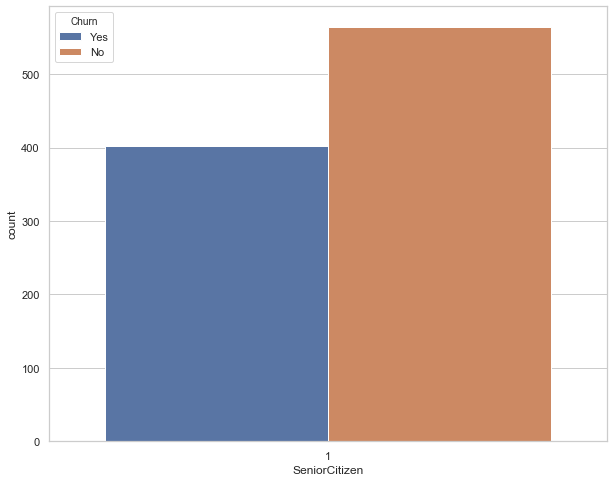

In [59]:
category_plot(senior_citizen_churn, 'SeniorCitizen')

There is lower churn rate among senior citizens

#### Hypothesis 6: there is a relation between number of months with company and churn rate

In [60]:
tenure_churn = (dataframe[dataframe['Churn'] == 'Yes'][['Churn', 'tenure']]
                .reset_index(drop=True))

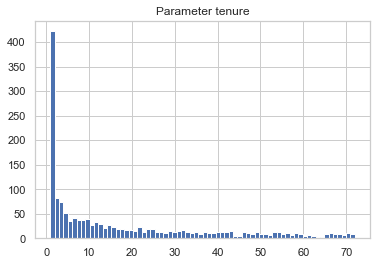

In [61]:
hist_plot(tenure_churn, 'tenure', 70)

In [62]:
tenure_not_churn = (dataframe[dataframe['Churn'] == 'No'][['Churn', 'tenure']]
                    .reset_index(drop=True))

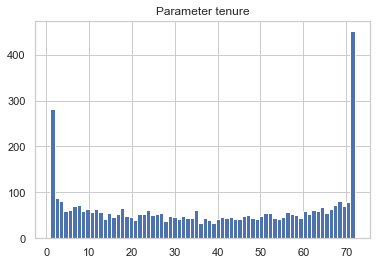

In [63]:
hist_plot(tenure_not_churn, 'tenure', 70)

It is noticeable that client who has long relationship with the company is less prone to churn. Perhaps, we could consider this metric as loyalty.

###  Feature engineering

In [82]:
dataframe['gender'] = dataframe['gender'].map({'Female': 0, 'Male': 1}).astype(int)
dataframe['Partner'] = dataframe['Partner'].map({'No': 0, 'Yes': 1}).astype(int)
dataframe['Dependents'] = dataframe['Dependents'].map({'No': 0, 'Yes': 1}).astype(int)

dataframe['tenure_с'] = pd.qcut(dataframe['tenure'], 4)
dataframe.loc[ dataframe['tenure'] <= 9.0, 'tenure']                                  = 0
dataframe.loc[(dataframe['tenure'] > 9.0) & (dataframe['tenure'] <= 29.0), 'tenure']  = 1
dataframe.loc[(dataframe['tenure'] > 29.0) & (dataframe['tenure'] <= 56.0), 'tenure'] = 2
dataframe.loc[ dataframe['tenure'] > 56.0, 'tenure']                                  = 3
dataframe['tenure'] = dataframe['tenure'].astype(int)
dataframe = dataframe.drop(columns=['tenure_с'], axis=1)

dataframe['PhoneService'] = dataframe['PhoneService'].map({'No': 0, 'Yes': 1}).astype(int)
dataframe['MultipleLines'] = (dataframe['MultipleLines']
                              .map({'No phone service': 0, 'No': 1, 'Yes': 2})
                              .astype(int))
dataframe['InternetService'] = (dataframe['InternetService']
                                .map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
                                .astype(int))
dataframe['OnlineSecurity'] = (dataframe['OnlineSecurity']
                               .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                               .astype(int))
dataframe['OnlineBackup'] = (dataframe['OnlineBackup']
                             .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                             .astype(int))
dataframe['DeviceProtection'] = (dataframe['DeviceProtection']
                                 .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                                 .astype(int))
dataframe['TechSupport'] = (dataframe['TechSupport']
                            .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                            .astype(int))
dataframe['StreamingTV'] = (dataframe['StreamingTV']
                            .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                            .astype(int))
dataframe['StreamingMovies'] = (dataframe['StreamingMovies']
                                .map({'No internet service': 2, 'No': 0, 'Yes': 1})
                                .astype(int))
dataframe['Contract'] = (dataframe['Contract']
                         .map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
                         .astype(int))
dataframe['PaperlessBilling'] = (dataframe['PaperlessBilling']
                                 .map({'No': 0, 'Yes': 1})
                                 .astype(int))

dataframe['PaymentMethod'] = dataframe['PaymentMethod'].map({
    'Electronic check': 0, 'Mailed check': 1,
    'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3, 
}).astype(int)

dataframe['MonthlyCharges_с'] = pd.qcut(dataframe['MonthlyCharges'], 4)
dataframe.loc[ dataframe['MonthlyCharges'] <= 35.65, 'MonthlyCharges'] = 0
(dataframe
 .loc[(dataframe['MonthlyCharges'] > 35.65) 
      & (dataframe['MonthlyCharges'] <= 70.4), 'MonthlyCharges']) = 1
(dataframe
 .loc[(dataframe['MonthlyCharges'] > 70.4) 
      & (dataframe['MonthlyCharges'] <= 89.9), 'MonthlyCharges']) = 2
dataframe.loc[ dataframe['MonthlyCharges'] > 89.9, 'MonthlyCharges'] = 3
dataframe['MonthlyCharges'] = dataframe['MonthlyCharges'].astype(int)
dataframe = dataframe.drop(columns=['MonthlyCharges_с'], axis=1)

dataframe['TotalCharges_c'] = pd.qcut(dataframe['TotalCharges'], 4)
dataframe.loc[ dataframe['TotalCharges'] <= 404.312, 'TotalCharges'] = 0
(dataframe
 .loc[(dataframe['TotalCharges'] > 404.312) 
      & (dataframe['TotalCharges'] <= 1412.15), 'TotalCharges']) = 1
(dataframe
 .loc[(dataframe['TotalCharges'] > 1412.15) 
      & (dataframe['TotalCharges'] <= 3846.962), 'TotalCharges']) = 2
dataframe.loc[ dataframe['TotalCharges'] > 3846.962, 'TotalCharges'] = 3
dataframe['TotalCharges'] = dataframe['TotalCharges'].astype(int)
dataframe = dataframe.drop(columns=['TotalCharges_c'], axis=1)

dataframe['Churn'] = dataframe['Churn'].map({'No': 0, 'Yes': 1}).astype(int)

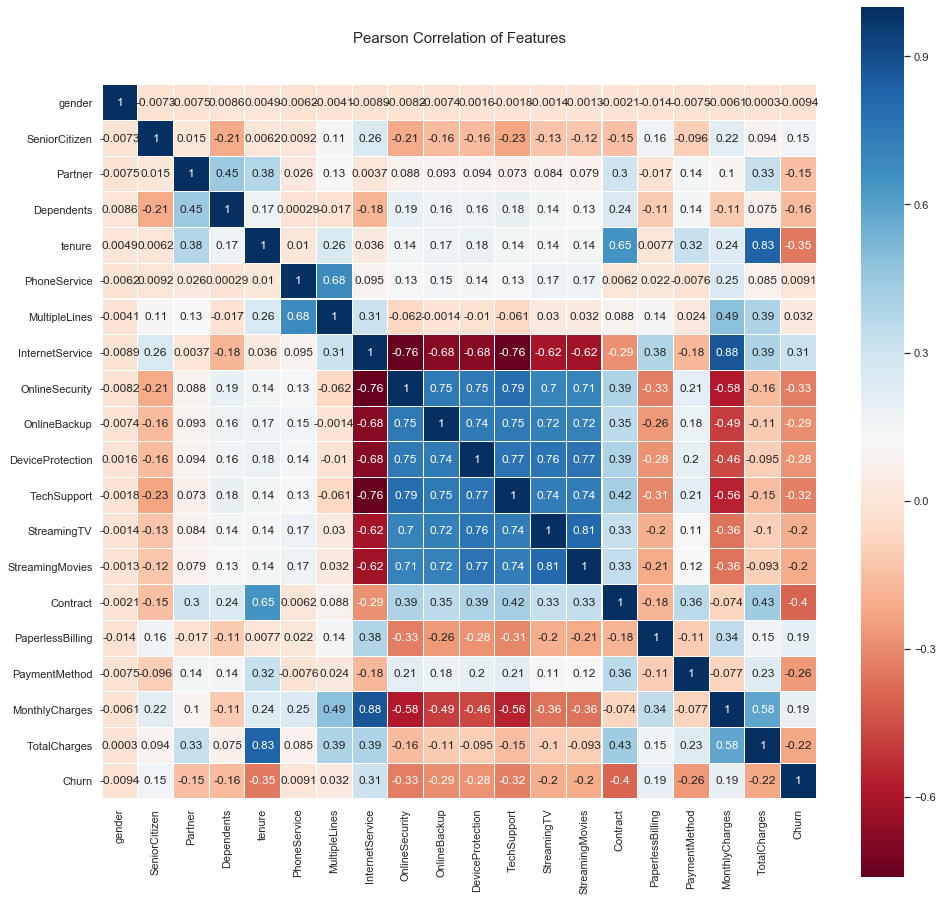

In [83]:
colormap = plt.cm.RdBu
plt.figure(figsize=(16,16))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(dataframe.astype(float).corr(), linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

#### Contract feature and target value churn

There is a noticable inverse correlation of -0.4 for this feature and target value. This could be pretty logical: those who has short-term contract more prone to churn.

#### Correlation between tenure and TotalCharges

There is a strong correlation between tenure and TotalCharges features. This could be explainable as well: the more client with the company, the more charges.
Сильная корреляция между признаками tenure и TotalCharges, что вполне логично: чем больше клиент месяцев с компанией, тем больше сумма затрат.

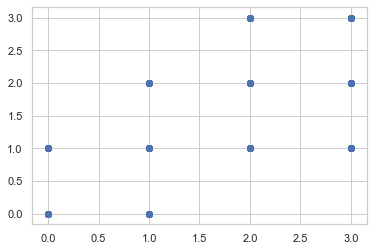

In [84]:
plt.scatter(dataframe.tenure, dataframe.TotalCharges)
plt.show()

#### Correlation between InternetService and MonthlyCharges features

It is noticable string correlation between these features (0.88). If there is a internet service activated, there is a higher costs.

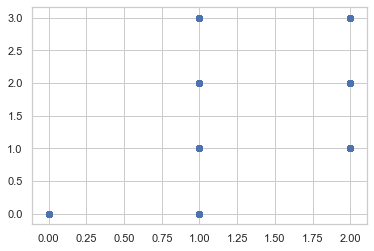

In [85]:
plt.scatter(dataframe.InternetService, dataframe.MonthlyCharges)
plt.show()

#### Correlations between internet services

Features with 8-13 indices correlates between each other in various degrees (>0.7) because clients use different internet services.

# 3. Build models and predict churn rate

In [86]:
X = dataframe.values
X = np.delete(X, -1, axis=1)
Y = dataframe.Churn.values

In [87]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

In [88]:
x_train_valid, x_valid, y_train_valid, y_valid = train_test_split(x_train,
                                                                  y_train,
                                                                  test_size=0.2,
                                                                  random_state=13)

In [89]:
skf = StratifiedKFold(n_splits=5, random_state=13)

#### Model selection

Because data is quite diverse and number of features equal to 19 then for churn rate prediction 
stacking (method of building ensembles) will be used based on basic models:

1. RandomForestClassifier()
- fits a number of decision tree classifiers on various sub-samples of the dataset
- uses averaging to improve the predictive accuracy and control over-fitting
2. C-Support Vector Classification SVC()
- parameter for regularization *С*
3. LogisticRegression()
- parameter for regularization *С*
4. GradientBoostingClassifier()
- boosting algorithm

XGBClassifier() is used as meta-algorithm

Best models parameters will be determined by grid search and 5-fold cross-validation.

In [90]:
rfc_params = {'n_estimators': range(10, 100, 10),
              'min_samples_leaf': range(1, 5)}
svc_params = {'kernel': ['linear', 'rbf'],
              'C': np.arange(0.1, 1, 0.2)}
lr_params = {'C': np.arange(0.5, 1, 0.1)}
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)}

rfc = RandomForestClassifier(random_state=13)
rfc_grid = GridSearchCV(rfc, rfc_params, scoring='recall', cv=skf)

svc = SVC(random_state=13)
svc_grid = GridSearchCV(svc, svc_params, scoring='recall', cv=skf)

lr = LogisticRegression(random_state=13)
lr_grid = GridSearchCV(lr, lr_params, scoring='recall', cv=skf)

gbc = GradientBoostingClassifier(random_state=13)
gbc_grid = GridSearchCV(gbc, gbc_params, scoring='recall', cv=skf)

rfc_grid.fit(x_train_valid, y_train_valid)    
rfc_min_samples_leaf = rfc_grid.best_params_['min_samples_leaf']
rfc_n_estimators = rfc_grid.best_params_['n_estimators'],

svc_grid.fit(x_train_valid, y_train_valid)    
svc_c = svc_grid.best_params_['C']
svc_kernel = svc_grid.best_params_['kernel']

lr_grid.fit(x_train_valid, y_train_valid)
lr_c = lr_grid.best_params_['C']

gbc_grid.fit(x_train_valid, y_train_valid)
gbc_learning_rate = gbc_grid.best_params_['learning_rate']

rfc_predicted = rfc_grid.predict(x_valid)
rfc_accuracy = accuracy_score(y_valid, rfc_predicted)
rfc_recall = recall_score(y_valid, rfc_predicted)

svc_predicted = svc_grid.predict(x_valid)
svc_accuracy = accuracy_score(y_valid, svc_predicted)
svc_recall = recall_score(y_valid, svc_predicted)

lr_predicted = lr_grid.predict(x_valid)
lr_accuracy = accuracy_score(y_valid, lr_predicted)
lr_recall = recall_score(y_valid, lr_predicted)

gbc_predicted = gbc_grid.predict(x_valid)
gbc_accuracy = accuracy_score(y_valid, gbc_predicted)
gbc_recall = recall_score(y_valid, gbc_predicted)

print(f'RFC model best parameters {rfc_grid.best_params_}')
print(f'SVC model best parameters {svc_grid.best_params_}')
print(f'LR model best parameters {lr_grid.best_params_}')
print(f'GBC model best parameters {gbc_grid.best_params_}')

RFC model best parameters {'min_samples_leaf': 3, 'n_estimators': 10}
SVC model best parameters {'C': 0.9000000000000001, 'kernel': 'linear'}
LR model best parameters {'C': 0.5}
GBC model best parameters {'learning_rate': 0.1}


In [91]:
xgb_params = {'n_estimators': range(10, 100, 5),
          'eta': np.arange(0.1, 1., .1),
          'min_child_weight': range(1, 10, 1),
          'subsample': np.arange(0.1, 1., 0.2)}

meta = XGBClassifier(random_state=13)
meta_grid = GridSearchCV(meta, xgb_params, cv=skf)

x_train_meta = np.concatenate((rfc_predicted.reshape(-1, 1),
                               svc_predicted.reshape(-1, 1),
                               lr_predicted.reshape(-1, 1),
                               gbc_predicted.reshape(-1, 1)), axis=1)

meta_grid.fit(x_train_meta, y_valid)
print(f'Meta algorithm best parameters: {meta_grid.best_params_}')
eta = meta_grid.best_params_['eta']
min_child_weight = meta_grid.best_params_['min_child_weight']
n_estimators = meta_grid.best_params_['n_estimators']
subsample = meta_grid.best_params_['subsample']

Meta algorithm best parameters: {'eta': 0.6, 'min_child_weight': 4, 'n_estimators': 95, 'subsample': 0.1}


In [92]:
rfc_best = RandomForestClassifier(min_samples_leaf=rfc_min_samples_leaf,
                                  n_estimators=rfc_n_estimators[0],
                                  random_state=13)
svc_best = SVC(C=svc_c, 
               kernel=svc_kernel, 
               random_state=13)

lr_best = LogisticRegression(C=lr_c,
                             random_state=13)

gbc_best = GradientBoostingClassifier(learning_rate=gbc_learning_rate,
                                      random_state=13)

models = [rfc_best, svc_best, lr_best, gbc_best]

meta_best = XGBClassifier(eta=eta, min_child_weight=min_child_weight,
                          n_estimators=n_estimators, subsample=subsample,
                          random_state=13)

stacking(models, meta_best, x_train, y_train, x_test, y_test, random_state=13, test_size=0.2, cv=5)

Accuracy score 0.8244147157190636
Recall score 0.550314465408805


# 4. Model quality comparison

Recall has been chosen as a target metric because there is a need to minimize the risk of skipping any positive result. In other words, we would like to prevent the situation such as model predicts that there is no churn for particular client when is fact that client had churn. We will monitor accuracy as well.

In [93]:
print('Accuracy:')
print(f'RFC accuracy: {rfc_accuracy}')       
print(f'SVC accuracy: {svc_accuracy}')   
print(f'LR accuracy: {lr_accuracy}')
print(f'GBC accuracy: {gbc_accuracy}')
print('Recall:')
print(f'RFC recall: {rfc_recall}')
print(f'SVC recall: {svc_recall}')
print(f'LR recall: {lr_recall}')
print(f'GBC recall: {gbc_recall}')

Accuracy:
RFC accuracy: 0.797071129707113
SVC accuracy: 0.801255230125523
LR accuracy: 0.8075313807531381
GBC accuracy: 0.8127615062761506
Recall:
RFC recall: 0.45525291828793774
SVC recall: 0.4357976653696498
LR recall: 0.490272373540856
GBC recall: 0.5019455252918288


It is noticable that hte more accurate algorithm among basic ones is GradientBoostingClassifier with metrics recall = 0.5019 and accuracy = 0.8128.

Stacking meta-algorithm based on basic models has metrics recall = 0.5503 and accuracy = 0.8244 which is more accurate.

## General conclusions

1. Proposed portrait of client for high churn rate: client with month-to-month contract, using fiber optic as internet service, without partner, using electronic check as payment method, recently started using company services.
2. Stacking has been chosen as method for churn rate prediction based on basic models: random forest, c-support vector classification, logit, gradient boosting classifier
3. The most accurate algorithm GradientBoostingClassifier among basic ones has recall metric equal to 0.5019
4. Meta-algorithm predicts churn with recall metric equal recall = 0.5503
5. Recall is not high, so there are some suggestions to improve this metric:
- enlarge the set of parameters for basic models using grid search, 
- use other models (KNN),
- use derivative features,
- try to use StandardScaler() for numeric features